### Packages 

In [ ]:
from google.colab import files
from drive.MyDrive.simple_model_definition import networkLinear, LinearBlock, identityNN
from drive.MyDrive.gev_loss import simpleGEVloss
from drive.MyDrive.dataloaders import BaseDataLoader, DataLoader2
from drive.MyDrive.training_modules import NeuralTrainer, Diagnostic
from drive.MyDrive.schedulers import CyclicCosAnnealingLR, CyclicLinearLR
from drive.MyDrive.models_class1 import ModuleCustom, Model_unique_station

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
import torch
import matplotlib.pyplot as plt

import math
import time
import numpy as np

import torch
import torch.nn as nn
from torch.nn import LSTM
import torch.nn.functional as F

from tqdm import tqdm

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Setting

In [ ]:
# Settings
Station_of_interest = None           # if None, all station used
Duration_of_interest = "all"          # if "all", all durations are used. Otherwise, must be amond [5, 10, ..., 1440]

# Training
Proportion_of_stations_test = 0.1    # ~ 16 stations will be used as validation
Train_dataset_relative_size = 0.8    # 80% of observation is used for training
Nb_time_dataset_is_recreated = 10    # retrain model 10 times on a new dataset, following previous settings
Nb_bootstrapping = 5                 # for each dataset, fit model 5 times (potentially using residual bootstrapping or something similar)

Order_basis = 2
use_seed = None

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Load data, create dataset

In [ ]:
monthly_maxima = pd.read_csv("/content/drive/MyDrive/data_monthly.csv")
monthly_maxima.drop("Unnamed: 0", inplace = True, axis=1)
monthly_maxima

,id,year,month,dur,int,X,Y,basin,alt
0,69505,1996,Jan,5,40.800,-84.148057,10.165240,69,1899
1,69505,1997,Jan,5,24.000,-84.148057,10.165240,69,1899
2,69505,1998,Jan,5,1.200,-84.148057,10.165240,69,1899
3,69505,1999,Jan,5,13.200,-84.148057,10.165240,69,1899
4,69505,2000,Jan,5,37.200,-84.148057,10.165240,69,1899
...,...,...,...,...,...,...,...,...,...
359203,98080,2016,Dec,1440,0.846,-83.386662,9.080118,98,434
359204,98080,2017,Dec,1440,0.296,-83.386662,9.080118,98,434
359205,98080,2018,Dec,1440,1.408,-83.386662,9.080118,98,434
359206,98080,2019,Dec,1440,0.404,-83.386662,9.080118,98,434


In [ ]:
stations_training_testing = pd.read_csv("/content/drive/MyDrive/data_training_testing.csv")
stations_training_testing.drop("Unnamed: 0", inplace = True, axis=1)

list_stations_training = list(stations_training_testing[stations_training_testing["train"] == True]["id"].values)
list_stations_testing = list(stations_training_testing[stations_training_testing["train"] == False]["id"].values)
print(*list_stations_training, sep = ", ")
print("----------")
print(*list_stations_testing, sep = ", ")

73046, 78020, 98015, 69576, 98043, 69654, 79012, 84122, 84136, 88028, 76012, 69524, 84124, 69698, 73124, 88034, 79020, 69542, 88018, 69522, 69700, 73055, 98023, 98021, 75028, 73098, 88024, 73074, 98057, 98050, 88032, 79010, 98020, 69544, 69628, 98059, 69624, 76033, 76050, 69670, 69570, 69547, 98036, 98039, 94014, 73042, 75007, 84043, 69530, 69694, 84130, 69662, 76048, 69632, 75004, 69598, 69596, 69581, 69553, 84034, 74036, 69563, 69612, 76006, 98037, 79014, 74019, 69630, 69696, 69668, 69604, 73134, 69550, 84096, 69571, 76044, 76018, 73028, 69686, 78018, 73140, 69532, 76024, 98058, 69572, 76020, 73079, 75003, 98044, 98034, 69505, 73128, 76013, 69552, 75005, 98019, 76021, 98012, 98080, 98078, 88020, 87010, 76038, 69548, 69545, 88023, 69574, 73027, 69549, 69636, 69561, 98011, 84114, 98040, 69520, 76022, 88030, 78002, 73148, 76036, 75002, 73047, 69578
----------
69507, 69551, 69582, 69583, 69587, 69588, 69589, 69608, 69614, 69616, 69620, 69626, 69634, 69638, 69656, 69674, 69682, 73011, 730

In [ ]:
durations = list(set(monthly_maxima["dur"]))
station_ids = list(set(monthly_maxima["id"]))
monthly_maxima["int_frechet"] = np.Inf
for dur in range(len(durations)):
  for id in range(len(station_ids)):
    mask = (monthly_maxima["dur"] == durations[dur]) & (monthly_maxima["id"] == station_ids[id])
    ecdf = ECDF(monthly_maxima[mask]["int"])
    monthly_maxima.loc[mask, "int_frechet"] = monthly_maxima[mask]["int"].apply(lambda x: -1/np.log(ecdf(x)))
    
mask = monthly_maxima['int_frechet'] != -np.inf
monthly_maxima.loc[~mask, 'int_frechet'] = monthly_maxima.loc[mask, 'int_frechet'].min()

Simple check

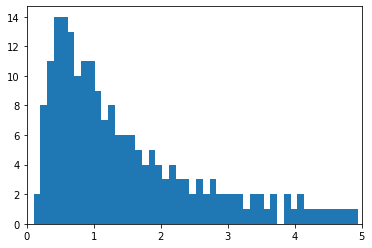

In [ ]:
mask = (monthly_maxima["dur"] == 1440) & (monthly_maxima["id"] == 75022)
plt.hist(monthly_maxima.loc[mask, "int_frechet"], bins = np.linspace(0, 10, 100))
plt.xlim((0, 5))
plt.show()

In [ ]:
monthly_maxima_labelMonth = monthly_maxima.copy()
look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
look_up_inv = {v: int(i) for i, (k, v) in enumerate(look_up.items())}
monthly_maxima_labelMonth['month'] = monthly_maxima_labelMonth['month'].map(look_up_inv)

for j in range(Order_basis):
    monthly_maxima_labelMonth['month_cos_'+str(j)] = np.cos((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
    monthly_maxima_labelMonth['month_sin_'+str(j)] = np.sin((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
# monthly_maxima_labelMonth = monthly_maxima_labelMonth.loc[(monthly_maxima_labelMonth.loc[:,'id'] == station_of_interest), :]
monthly_maxima_labelMonth

,id,year,month,dur,int,X,Y,basin,alt,int_frechet,month_cos_0,month_sin_0,month_cos_1,month_sin_1
0,69505,1996,0,5,40.800,-84.148057,10.165240,69,1899,0.953651,1.000000,0.0,1.0,0.000000
1,69505,1997,0,5,24.000,-84.148057,10.165240,69,1899,0.647963,1.000000,0.0,1.0,0.000000
2,69505,1998,0,5,1.200,-84.148057,10.165240,69,1899,0.183307,1.000000,0.0,1.0,0.000000
3,69505,1999,0,5,13.200,-84.148057,10.165240,69,1899,0.406572,1.000000,0.0,1.0,0.000000
4,69505,2000,0,5,37.200,-84.148057,10.165240,69,1899,0.868617,1.000000,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359203,98080,2016,11,1440,0.846,-83.386662,9.080118,98,434,0.821546,0.866025,-0.5,0.5,-0.866025
359204,98080,2017,11,1440,0.296,-83.386662,9.080118,98,434,0.505214,0.866025,-0.5,0.5,-0.866025
359205,98080,2018,11,1440,1.408,-83.386662,9.080118,98,434,1.266185,0.866025,-0.5,0.5,-0.866025
359206,98080,2019,11,1440,0.404,-83.386662,9.080118,98,434,0.566321,0.866025,-0.5,0.5,-0.866025


### Function definition

#### Dataloader

In [ ]:
class DataLoader3(BaseDataLoader):
    """ Assumption: dataInput and dataOutput are pd.DataFrame in this case. Also, 
    """

    def __init__(self, 
                 data_DF, 
                 batch_size, 
                 maxIterations = None, 
                 mixed_column_names = None, 
                 column_name_input = None, 
                 column_name_output = None,
                 column_name_check = None,
                 value_check = None,
                 symmetric_samples = True,
                 estimates_of_extremal_coefficient = False
                 ):
        self.mixed_column_names = mixed_column_names

        if self.mixed_column_names is None:
          self.mixed_column_names = dataInput.columns
        self.fixed_columns_names = list(set(data_DF.columns) - set(self.mixed_column_names))

        self.column_name_input = column_name_input
        self.column_name_output = column_name_output

        self.column_name_check = column_name_check
        self.value_check = value_check
        if self.column_name_check is not None: assert self.value_check is not None
        if self.value_check is not None: assert self.column_name_check is not None
        if self.column_name_check is not None: assert self.column_name_check in self.mixed_column_names

        self.DF_split = [y for x, y in data_DF.groupby(self.fixed_columns_names)]
        if self.column_name_check is not None:
          self.DF_split = [df for df in self.DF_split if self.value_check in df[self.column_name_check].values]
        self.DF_split = [df for df in self.DF_split if len(df)>1] # avoid observations with only one station...

        self.batch_size = batch_size
        self.count = 0
        self.nb_epoch = 0
        self.maxIterations = maxIterations
        if self.maxIterations is None:
            self.maxIterations = np.Inf

        self.symmetric_samples = symmetric_samples

        self.estimates_of_extremal_coefficient = estimates_of_extremal_coefficient

        if estimates_of_extremal_coefficient:
          stations = list(set(data_DF["id"]))
          durations = list(set(data_DF["log_duration"]))
          self.empirical_V = {}
          for s1 in tqdm(stations):
            for s2 in stations:
              if s1 == s2: continue
              df = empirical_extremal_coefficient(data_DF, s1, s2, 
                                                  ref_lab = "id", 
                                                  quantity_lab = "int_frechet")
              for du in durations:
                df_ = df[(df["log_duration"] == du)]
                x = 1/df_["int_frechet_x"]
                y = 1/df_["int_frechet_y"]
                empirical_V[(s1, s2, du)] = 1/np.mean(np.minimum(x, y))
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.count += 1
        if self.count > self.maxIterations:
            raise StopIteration
        return self.sample()
        
    def reset(self):
        self.count = 0
    

    def sample(self, verbose = False):
      return self.getSample(self.batch_size, verbose = verbose)

    def getSample(self, size = 1, verbose = False):
      chosen_subsets = np.random.choice(len(self.DF_split), size = size, replace = True)
      x1_list = []
      x2_list = []

      if verbose:
        iterator = tqdm(range(len(chosen_subsets)))
      else:
        iterator = range(len(chosen_subsets))
        
      for sub in iterator:
        df = self.DF_split[chosen_subsets[sub]]
        if self.column_name_check is not None:
          x1_list.append(df[df[self.column_name_check] == self.value_check].sample())
          x2_list.append(df[df[self.column_name_check] != self.value_check].sample())
        else:
          # x1_list.append(df.sample())
          # x2_list.append(df.sample())
          df_sample = np.random.choice(len(df), size = 2, replace = False)
          x1_list.append(df.iloc[df_sample[0],:])
          x2_list.append(df.iloc[df_sample[1],:])

        if self.symmetric_samples:
          l1_last = x1_list[-1]
          x1_list.append(x2_list[-1])
          x2_list.append(l1_last)

      if self.column_name_check is not None:
        inputsx1 = pd.concat(x1_list)
        inputsx2 = pd.concat(x2_list)
      else:
        inputsx1 = pd.concat(x1_list, axis = 1).transpose()
        inputsx2 = pd.concat(x2_list, axis = 1).transpose()
        
      input_batch_covariates1 = torch.from_numpy(inputsx1[self.column_name_input].to_numpy())
      input_batch_covariates2 = torch.from_numpy(inputsx2[self.column_name_input].to_numpy())
      output_batch_int1 = torch.from_numpy(inputsx1[self.column_name_output].to_numpy())
      output_batch_int2 = torch.from_numpy(inputsx2[self.column_name_output].to_numpy())

      return {"input": {"cov1": input_batch_covariates1, 
                        "cov2": input_batch_covariates2},
              "output": {"int1": output_batch_int1,
                         "int2": output_batch_int2}
              }

    def sample_pair(self, val_1, val_2, column_name_check = None, size=None):
      if column_name_check is None: assert self.column_name_check is not None

      DF_split_v = [df for df in self.DF_split if (val_1 in df[column_name_check].values) & (val_2 in df[column_name_check].values)]
      # print(DF_split_v)
      if size is not None:
        chosen_subsets = np.random.choice(len(DF_split_v), size = size, replace = True)
      else:
        chosen_subsets = np.arange(len(DF_split_v))
      x1_list = []
      x2_list = []
      for sub in range(len(chosen_subsets)):
        df = DF_split_v[chosen_subsets[sub]]
        x1_list.append(df[df[column_name_check] == val_1].sample())
        x2_list.append(df[df[column_name_check] == val_2].sample())

        if self.symmetric_samples:
          l1_last = x1_list[-1]
          x1_list.append(x2_list[-1])
          x2_list.append(l1_last)

      inputsx1 = pd.concat(x1_list)
      inputsx2 = pd.concat(x2_list)
      input_batch_covariates1 = torch.from_numpy(inputsx1[self.column_name_input].to_numpy())
      input_batch_covariates2 = torch.from_numpy(inputsx2[self.column_name_input].to_numpy())
      output_batch_int1 = torch.from_numpy(inputsx1[self.column_name_output].to_numpy())
      output_batch_int2 = torch.from_numpy(inputsx2[self.column_name_output].to_numpy())

      return {"input": {"cov1": input_batch_covariates1, 
                        "cov2": input_batch_covariates2},
              "output": {"int1": output_batch_int1,
                         "int2": output_batch_int2}
              }

#### Create dataloaders, data split

In [ ]:
# example: 
# name_covariates = ["X", "Y", "alt", "log_duration", "dur"]
# inputs_columns = ["X", "Y", "alt", "log_duration", "dur", "year", "int_frechet", "month", "id", "int"]
def create_training_datasets(data_input, 
                             inputs_columns,  # ex: ["X", "Y", "alt", "log_duration", "dur", "year", "int_frechet", "month", "id", "int"]
                             name_covariates, # ex: ["X", "Y", "alt", "log_duration", "dur"]
                             train_size = 0.1,  # 10% data used for testing (among data of stations used during the process)
                             proportion_station_train = 0.8,   # 80% of the stations used to fit the model, the rest is used to evaluate it
                             station_reference = None,  # if one wants to fix a station
                             duration = None,   # if the duration is fixed
                             seed_val = None,
                             covariates_to_rescale = None # ex: ['X', 'Y', 'alt', "log_duration"]
                             ):
  
  # Step 1: remove random stations from the dataset
  list_stations = sorted(list(set(data_input["id"])))  # get all stations
  repeat_sampling = True
  while repeat_sampling:
    indices = np.random.choice(len(list_stations), size = int(len(list_stations) * proportion_station_train), replace = False)
    list_stations_training = [list_stations[i] for i in indices]
    if station_reference is not None and station_reference not in list_stations_training:
      repeat_sampling = True
      print("Repeating... (station of reference is not in the set of stations used for the training)")
    else:
      repeat_sampling = False

  mask = data_input['id'].isin(list_stations_training)
  data_input_station_training, data_input_station_testing = data_input[mask], data_input[~mask]

  if station_reference is not None:
    data_input_station_testing = pd.concat([data_input_station_testing, data_input[data_input['id'] == station_reference]])


  X_train1, X_test1 = train_test_split(data_input_station_training, 
                                       test_size = 1.0-train_size,
                                       random_state = seed_val)

  scaler = MinMaxScaler()
  if covariates_to_rescale is not None:
    X_train1.loc[:, covariates_to_rescale] = scaler.fit_transform(X_train1[covariates_to_rescale])
    X_test1.loc[:, covariates_to_rescale] = scaler.transform(X_test1[covariates_to_rescale])
    if not data_input_station_testing.empty:
      data_input_station_testing.loc[:, covariates_to_rescale] = scaler.transform(data_input_station_testing[covariates_to_rescale])

  if duration is not None:
    X_train1 = X_train1[X_train1["dur"] == duration]
    X_test1 = X_test1[X_test1["dur"] == duration]
    if not data_input_station_testing.empty:
      data_input_station_testing = data_input_station_testing[data_input_station_testing["dur"] == duration]

  dataloader_Training_1 = DataLoader3(
    data_DF = X_train1, 
    maxIterations = None, 
    mixed_column_names = ["X", "Y", "alt", "int_frechet", "id", "int"], 
    column_name_input = name_covariates, 
    column_name_output = ["int_frechet"],
    column_name_check = "id" if station_reference is not None else None,
    value_check = "id" if station_reference is not None else None,
    batch_size = 5,
    symmetric_samples = False,
    estimates_of_extremal_coefficient = False
    )
  
  dataloader_Testing_1 = DataLoader3(
    data_DF = X_test1, 
    maxIterations = None, 
    mixed_column_names = ["X", "Y", "alt", "int_frechet", "id", "int"], 
    column_name_input = name_covariates, 
    column_name_output = ["int_frechet"],
    column_name_check = "id" if station_reference is not None else None,
    value_check = "id" if station_reference is not None else None,
    batch_size = 5,
    symmetric_samples = False,
    estimates_of_extremal_coefficient = False
    )
  
  if not data_input_station_testing.empty:
    dataloader_Testing_missing_stations = DataLoader3(
      data_DF = data_input_station_testing, 
      maxIterations = None, 
      mixed_column_names = ["X", "Y", "alt", "int_frechet", "id", "int"], 
      column_name_input = name_covariates, 
      column_name_output = ["int_frechet"],
      column_name_check = "id" if station_reference is not None else None,
      value_check = "id" if station_reference is not None else None,
      batch_size = 5,
      symmetric_samples = False,
      estimates_of_extremal_coefficient = False
      )
  else:
    dataloader_Testing_missing_stations = None

  return dataloader_Training_1, dataloader_Testing_1, dataloader_Testing_missing_stations, scaler, list_stations_training

In [ ]:
monthly_maxima_labelMonth["log_duration"] = np.log(monthly_maxima_labelMonth["dur"])

d1, d2, d3, scaler, _ = create_training_datasets(data_input = monthly_maxima_labelMonth, 
                             inputs_columns = ["X", "Y", "alt", "log_duration", "dur", "year", "int_frechet", "month", "id", "int"],  
                             name_covariates = ["X", "Y", "alt", "log_duration", "dur"],
                             train_size = Train_dataset_relative_size,  
                             proportion_station_train = 1.0 - Proportion_of_stations_test,   
                             station_reference = Station_of_interest,  
                             duration = None if Duration_of_interest == "all" else Duration_of_interest, 
                             seed_val = None,
                             covariates_to_rescale = ['X', 'Y', 'alt', "log_duration"] 
                             )

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
d3.getSample(size = 10)

{'input': {'cov1': tensor([[1.4521e-01, 8.7729e-01, 3.0319e-01, 6.3280e-01, 1.8000e+02],
          [2.9729e-01, 7.5772e-01, 1.6014e-01, 1.0000e+00, 1.4400e+03],
          [2.9729e-01, 7.5772e-01, 1.6014e-01, 7.5520e-01, 3.6000e+02],
          [2.2831e-01, 7.9761e-01, 1.8842e-01, 6.3280e-01, 1.8000e+02],
          [5.3347e-01, 4.2697e-01, 6.9122e-01, 5.6120e-01, 1.2000e+02],
          [7.8846e-01, 6.0246e-02, 1.7955e-01, 3.1640e-01, 3.0000e+01],
          [2.9729e-01, 7.5772e-01, 1.6014e-01, 6.3280e-01, 1.8000e+02],
          [9.4772e-01, 2.6315e-02, 3.7192e-01, 3.1640e-01, 3.0000e+01],
          [6.7533e-01, 1.8352e-01, 2.0750e-01, 5.6120e-01, 1.2000e+02],
          [5.4262e-01, 3.9093e-01, 5.2417e-01, 1.2240e-01, 1.0000e+01]],
         dtype=torch.float64),
  'cov2': tensor([[2.2831e-01, 7.9761e-01, 1.8842e-01, 6.3280e-01, 1.8000e+02],
          [2.9737e-01, 7.8381e-01, 1.0128e-01, 1.0000e+00, 1.4400e+03],
          [2.9737e-01, 7.8381e-01, 1.0128e-01, 7.5520e-01, 3.6000e+02],
       

#### Model definition

In [ ]:
from scipy.stats import t as t_student
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
import torchviz

class tStudent(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, df = 1.0, device = "cpu"):
        ctx.save_for_backward(x)
        ctx.df = df
        ctx.device = device
        return torch.as_tensor(t_student.cdf(x.cpu().detach().numpy(), df), dtype=x.dtype).to(device)

    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        cst = torch.exp(torch.lgamma(torch.tensor((1+ctx.df)/2)))/(torch.exp(torch.lgamma(torch.tensor(ctx.df/2))) * torch.sqrt(torch.tensor(ctx.df*torch.pi)))
        result = torch.as_tensor(cst * (1 + (x**2)/ctx.df)**(-((ctx.df+1)/2)), dtype=grad_out.dtype).to(ctx.device)
        return result * grad_out, None, None

test_tStudent = True
if test_tStudent:
  x = torch.tensor(1., requires_grad=True, dtype=torch.double).clone()

  # Validate our gradients using gradcheck
  print("Test gradient OK? ", torch.autograd.gradcheck(tStudent.apply, (x, 3)))
  print("Test second gradient OK? ", torch.autograd.gradgradcheck(tStudent.apply, (x, 3)))

  x = torch.tensor(10.0, requires_grad=True).clone()
  out = tStudent.apply(x)
  grad_x, = torch.autograd.grad(out, x, create_graph=True)
  torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-mkrkiwyk
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-mkrkiwyk
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4991 sha256=6cebe52713aba22c740576f29573457e115037125067a322ca381ea174a42527
  Stored in directory: /tmp/pip-ephem-wheel-cache-hb3virp9/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz
Test gradient OK?  True
Test second gradient OK?  True


In [ ]:
class model_non_stationarity_t_extremal_basic(nn.Module):
  def __init__(self, covariance_2d, df, smooth):
    super(model_non_stationarity_t_extremal_basic, self).__init__()
    self.covariance_2d = covariance_2d
    self.df = df
    self.smooth = smooth
    self.device = device
    self.matrix_param1 = torch.nn.Parameter(torch.ones(1))
    self.matrix_param2 = torch.nn.Parameter(torch.ones(1))
    self.matrix_param3 = torch.nn.Parameter(torch.ones(1))
    self.matrix_param4 = torch.nn.Parameter(torch.zeros(1))

    self.smooth_2 = None

  def get_matrix_parameters_basic_2d(self, input_cov):
    w_long = torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                  # >0
    w_lat = torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
    # w_alt = torch.exp(self.matrix_param3.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
    w_long_lat = torch.sigmoid(self.matrix_param4.unsqueeze(0).repeat(input_cov.shape[0], 1))*2-1     # in ]-1;1[
      
    w_long_lat = w_long_lat * torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1)) * torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))
    diagonal_elements = torch.cat((w_long.view(-1, 1), w_lat.view(-1, 1)), axis=1)

    device = self.device

    term1 = torch.tensor([[0, 1]], device = device).view(2,1) * torch.tensor([[1, 0]], device = device).view(1,2)
    term1 = term1 + torch.transpose(term1, 0,1)
    term1 = term1.unsqueeze(0).repeat(input_cov.shape[0], 1, 1)

    Sigma = torch.diag_embed(diagonal_elements, dim1=1, dim2=2) + term1*w_long_lat.view(-1, 1).unsqueeze(2)
    return Sigma

  def get_matrix_parameters_basic_3d(self, input_cov):
    w_long = torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                  # >0
    w_lat = torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
    w_alt = torch.exp(self.matrix_param3.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
    w_long_lat = torch.sigmoid(self.matrix_param4.unsqueeze(0).repeat(input_cov.shape[0], 1))*2-1     # in ]-1;1[
      
    w_long_lat = w_long_lat * torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1)) * torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))
    diagonal_elements = torch.cat((w_long.view(-1, 1), w_lat.view(-1, 1), w_alt.view(-1, 1)), axis=1)

    device = self.device

    term1 = torch.tensor([[0, 1, 0]], device = device).view(3,1) * torch.tensor([[1, 0, 0]], device = device).view(1,3)
    term1 = term1 + torch.transpose(term1, 0,1)
    term1 = term1.unsqueeze(0).repeat(input_cov.shape[0], 1, 1)

    Sigma = torch.diag_embed(diagonal_elements, dim1=1, dim2=2) + term1*w_long_lat.view(-1, 1).unsqueeze(2)
    return Sigma

  def get_mat(self, input_cov1, input_cov2):
    if self.covariance_2d:
      sigma1 = self.get_matrix_parameters_basic_2d(input_cov1)
      sigma2 = self.get_matrix_parameters_basic_2d(input_cov2)
    else:
      sigma1 = self.get_matrix_parameters_basic_3d(input_cov1) 
      sigma2 = self.get_matrix_parameters_basic_3d(input_cov2) 

    return sigma1, sigma2

  def get_rho(self, input_cov1, input_cov2):
    if self.covariance_2d:
      delta = input_cov1[:,0:2] - input_cov2[:,0:2]     # h
    else:
      delta = input_cov1[:,0:3] - input_cov2[:,0:3]     # h

    sigma1, sigma2 = self.get_mat(input_cov1, input_cov2)
    mean_mat = (sigma1 + sigma2)/2

    Qdist = torch.sqrt(self.Q_dist(delta.unsqueeze(-1), torch.inverse(mean_mat))).squeeze(-1).squeeze(-1)
    Qdist = torch.clamp(Qdist, min=1e-10)

    rho = torch.linalg.det(sigma1)**(1/4) * torch.linalg.det(sigma2)**(1/4) * torch.linalg.det(mean_mat)**(-1/2)
    rho = rho * self.R(Qdist, alpha = self.smooth)
    
    return rho

  def forward(self, input_cov1, input_cov2, z1 = 1, z2 = 1):
    rho = self.get_rho(input_cov1, input_cov2)
    return self.loglikelihood(rho, z1, z2)

  def R(self, h, alpha):
    return torch.exp(-(h**alpha) + 1e-5)

  def Q_dist(self, h, mat):
    """ Dimensions: h: [B, 3 or 2, 1]; mat: [B, 3 or 2, 3 or 2] """
    return torch.transpose(h, 1, 2).matmul(mat.matmul(h))

  def F_fct(self, x, df, rho):
    return (x**(1/df) - rho)/((df+1)**(-1/2) * (1-rho**2)**(1/2))

  def student_t_density(self, x, df, cst):
    return cst * (1 + (x**2)/df)**(-((df+1)/2))

  def student_t_density_prime(self, x, df, cst):
    return -(df+1)/df * cst * x * (1 + (x**2)/df)**(-((df+3)/2))

  def loglikelihood(self, rho, z1, z2):
    device = self.device
    F_z1_z2 = self.F_fct(z1/z2, self.df, rho)
    F_z2_z1 = self.F_fct(z2/z1, self.df, rho)

    T_F_z1z2 = tStudent.apply(F_z1_z2, self.df+1, device).to(device)
    T_F_z2z1 = tStudent.apply(F_z2_z1, self.df+1, device).to(device)

    cst_K = (self.df+1)**(-1/2) * (1-rho**2)**(1/2)

    dF_z1z2_dz1 = 1/(cst_K * self.df * z2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz1 = -z2/(cst_K * self.df * z1**2) * (z2/z1)**(1/self.df - 1)

    dF_z1z2_dz2 = -z1/(cst_K * self.df * z2**2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz2 = 1/(cst_K * self.df * z1) * (z2/z1)**(1/self.df - 1)
    
    cst_t_student = torch.exp(torch.lgamma(torch.tensor((1+self.df)/2)))/(torch.exp(torch.lgamma(torch.tensor(self.df/2))) * torch.sqrt(torch.tensor(self.df*torch.pi)))
    tStudent_F_z2z1 = self.student_t_density(F_z2_z1, self.df+1, cst_t_student)
    tStudent_F_z1z2 = self.student_t_density(F_z1_z2, self.df+1, cst_t_student)

    V_ = 1/z1 * T_F_z2z1  + 1/z2 * T_F_z1z2

    dV_dz1 = -1/z1**2 * T_F_z2z1 + 1/z1 * tStudent_F_z2z1 * dF_z2z1_dz1 + 1/z2 * tStudent_F_z1z2 * dF_z1z2_dz1
    dV_dz2 = -1/z2**2 * T_F_z1z2 + 1/z2 * tStudent_F_z1z2 * dF_z1z2_dz2 + 1/z1 * tStudent_F_z2z1 * dF_z2z1_dz2

    dF_z1z2_dz1dz2 = -1/(cst_K * self.df**2 * z2**2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz1dz2 = -1/(cst_K * self.df**2 * z1**2) * (z2/z1)**(1/self.df - 1)

    dV_dz1dz2_part1 = -1/z1**2 * tStudent_F_z2z1 * dF_z2z1_dz2 - 1/z2**2 * tStudent_F_z1z2 * dF_z1z2_dz1
    dV_dz1dz2_part2_1 = 1/z1 * (self.student_t_density_prime(F_z2_z1, self.df+1, cst_t_student) * dF_z2z1_dz1*dF_z2z1_dz2 + tStudent_F_z2z1 * dF_z2z1_dz1dz2)
    dV_dz1dz2_part2_2 = 1/z2 * (self.student_t_density_prime(F_z1_z2, self.df+1, cst_t_student) * dF_z1z2_dz2*dF_z1z2_dz1 + tStudent_F_z1z2 * dF_z1z2_dz1dz2)

    dV_dz1dz2 = dV_dz1dz2_part1 + dV_dz1dz2_part2_1 + dV_dz1dz2_part2_2
    return -torch.mean(torch.log(dV_dz1*dV_dz2 - dV_dz1dz2) - V_)

In [ ]:
class model_non_stationarity_t_extremal(nn.Module):
  def __init__(self, 
               indices_factor, # = [0,1,2],
               indices_cov, # = [0,1,2], 
               indices_mat_delta, # = [0,1]
               df = 2.0, 
               smooth = 2.0, 
               covariance_2d = True, 
               smooth_2 = None, 
               device = "cpu"):
    super(model_non_stationarity_t_extremal, self).__init__()
    self.covariance_2d = covariance_2d
    self.df = df
    self.smooth = smooth
    self.smooth_2 = smooth_2
    self.device = device
    self.indices_factor = indices_factor
    self.indices_cov = indices_cov
    self.indices_mat_delta = indices_mat_delta

    if self.covariance_2d:
      self.linearBlock = nn.Sequential(*[nn.Linear(len(self.indices_cov), 100), nn.Sigmoid(), nn.BatchNorm1d(100), 
                                         nn.Linear(100, 20), nn.Sigmoid(), nn.BatchNorm1d(20),
                                         nn.Linear(20, 10), nn.Sigmoid(), nn.BatchNorm1d(10), 
                                         nn.Linear(10, 3)])
      assert len(self.indices_mat_delta) == 2
    else:
      self.linearBlock = nn.Sequential(*[nn.Linear(len(self.indices_cov), 100), nn.Sigmoid(), nn.BatchNorm1d(100), 
                                         nn.Linear(100, 20), nn.Sigmoid(), nn.BatchNorm1d(20),
                                         nn.Linear(20, 10), nn.Sigmoid(), nn.BatchNorm1d(10), 
                                         nn.Linear(10, 4)])
      assert len(self.indices_mat_delta) == 3
      
    if self.smooth_2 is not None:
      self.factor_a_block = nn.Sequential(*[nn.Linear(len(self.indices_factor), 10), nn.Sigmoid(), nn.BatchNorm1d(10), 
                                         nn.Linear(10, 20), nn.Sigmoid(), nn.BatchNorm1d(20), 
                                         nn.Linear(20, 10), nn.Sigmoid(), nn.BatchNorm1d(10), 
                                         nn.Linear(10, 1), nn.Sigmoid()])
    

  def get_mat(self, input_cov1, input_cov2):
    if self.covariance_2d:
      sigma1 = self.get_matrix_parameters_2d(input_cov1[:,self.indices_cov])
      sigma2 = self.get_matrix_parameters_2d(input_cov2[:,self.indices_cov])
    else:
      sigma1 = self.get_matrix_parameters(input_cov1[:,self.indices_cov]) # * (2*self.df)**(2/self.smooth)
      sigma2 = self.get_matrix_parameters(input_cov2[:,self.indices_cov]) # * (2*self.df)**(2/self.smooth)

    return sigma1, sigma2

  def get_factor(self, input_cov):
    a_1 = self.factor_a_block(input_cov[:,self.indices_factor]).squeeze(1)
    return a_1

  def get_rho(self, input_cov1, input_cov2):
    # if self.covariance_2d:
    delta = input_cov1[:,self.indices_mat_delta] - input_cov2[:,self.indices_mat_delta]     # h
    # else:
    #   delta = input_cov1[:,self.indices_mat_delta] - input_cov2[:,self.indices_mat_delta]     # h

    sigma1, sigma2 = self.get_mat(input_cov1, input_cov2)
    mean_mat = (sigma1 + sigma2)/2

    Qdist = torch.sqrt(self.Q_dist(delta.unsqueeze(-1), torch.inverse(mean_mat))).squeeze(-1).squeeze(-1)
    Qdist = torch.clamp(Qdist, min=1e-10)

    if self.smooth_2 is None:
      rho = torch.linalg.det(sigma1)**(1/4) * torch.linalg.det(sigma2)**(1/4) * torch.linalg.det(mean_mat)**(-1/2)
      rho = rho * self.R(Qdist, alpha = self.smooth)
    else:
      rho = torch.linalg.det(sigma1)**(1/4) * torch.linalg.det(sigma2)**(1/4) * torch.linalg.det(mean_mat)**(-1/2)
      rho1 = rho * self.R(Qdist, alpha = self.smooth)
      rho2 = rho * self.R(Qdist, alpha = self.smooth_2)
      # a_1 = self.factor_a_block(input_cov1[:,2].view(-1, 1)).squeeze(1)
      # a_2 = self.factor_a_block(input_cov2[:,2].view(-1, 1)).squeeze(1)
      a_1 = self.factor_a_block(input_cov1[:,self.indices_factor]).squeeze(1)
      a_2 = self.factor_a_block(input_cov2[:,self.indices_factor]).squeeze(1)
      rho = a_1 * a_2 * rho1 + (1.0-a_1)*(1.0-a_2)*rho2
      rho = rho/(torch.sqrt(a_1**2 + (1.0-a_1)**2) * torch.sqrt(a_2**2 + (1.0-a_2)**2))
    return rho

  def forward(self, input_cov1, input_cov2, z1 = 1, z2 = 1):
    rho = self.get_rho(input_cov1, input_cov2)
    return self.loglikelihood(rho, z1, z2)


  def get_matrix_parameters(self, input_cov):
    if len(input_cov.shape) == 1:
      input_cov = input_cov.view(-1, 1)
    
    W_ = self.linearBlock(input_cov)
    w_long = W_[:,0]
    w_lat = W_[:,1]
    w_alt = W_[:,2]
    w_long_lat = W_[:,3]

    w_long_lat = torch.sigmoid(w_long_lat)*2-1     # in ]-1;1[
    w_long_lat = w_long_lat * torch.exp(w_long) * torch.exp(w_lat)

    w_long = torch.exp(w_long)**2                  # >0
    w_lat = torch.exp(w_lat)**2                    # >0
    w_alt = torch.exp(w_alt)**2                    # >0

    diagonal_elements = torch.cat((w_long.view(-1, 1), w_lat.view(-1, 1), w_alt.view(-1, 1)), axis=1)

    # device = input_cov.get_device()
    device = self.device

    term1 = torch.tensor([[0, 1, 0]], device = device).view(3,1) * torch.tensor([[1, 0, 0]], device = device).view(1,3)
    term1 = term1 + torch.transpose(term1, 0,1)
    term1 = term1.unsqueeze(0).repeat(input_cov.shape[0], 1, 1)

    Sigma = torch.diag_embed(diagonal_elements, dim1=1, dim2=2) + term1*w_long_lat.view(-1, 1).unsqueeze(2)
    return Sigma

  # def get_matrix_parameters_basic(self, input_cov):
  #   w_long = torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                  # >0
  #   w_lat = torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
  #   w_alt = torch.exp(self.matrix_param3.unsqueeze(0).repeat(input_cov.shape[0], 1))**2                    # >0
  #   w_long_lat = torch.sigmoid(self.matrix_param4.unsqueeze(0).repeat(input_cov.shape[0], 1))*2-1     # in ]-1;1[
      

  #   w_long_lat = w_long_lat * torch.exp(self.matrix_param1.unsqueeze(0).repeat(input_cov.shape[0], 1)) * torch.exp(self.matrix_param2.unsqueeze(0).repeat(input_cov.shape[0], 1))

  #   diagonal_elements = torch.cat((w_long.view(-1, 1), w_lat.view(-1, 1), w_alt.view(-1, 1)), axis=1)

  #   # device = input_cov.get_device()
  #   device = self.device

  #   term1 = torch.tensor([[0, 1, 0]], device = device).view(3,1) * torch.tensor([[1, 0, 0]], device = device).view(1,3)
  #   term1 = term1 + torch.transpose(term1, 0,1)
  #   term1 = term1.unsqueeze(0).repeat(input_cov.shape[0], 1, 1)

  #   Sigma = torch.diag_embed(diagonal_elements, dim1=1, dim2=2) + term1*w_long_lat.view(-1, 1).unsqueeze(2)
  #   return Sigma

  def get_matrix_parameters_2d(self, input_cov):
    if len(input_cov.shape) == 1:
      input_cov = input_cov.view(-1, 1)

    W_ = self.linearBlock(input_cov)
    w_long = W_[:,0]
    w_lat = W_[:,1]
    w_long_lat = W_[:,2]

    w_long_lat = torch.sigmoid(w_long_lat)*2-1     # in ]-1;1[
    w_long_lat = w_long_lat * torch.exp(w_long) * torch.exp(w_lat)

    w_long = torch.exp(w_long)**2                  # >0
    w_lat = torch.exp(w_lat)**2                    # >0

    diagonal_elements = torch.cat((w_long.view(-1, 1), w_lat.view(-1, 1)), axis=1)

    # device = input_cov.get_device()
    device = self.device

    term1 = torch.tensor([[0, 1]], device = device).view(2,1) * torch.tensor([[1, 0]], device = device).view(1,2)
    term1 = term1 + torch.transpose(term1, 0,1)
    term1 = term1.unsqueeze(0).repeat(input_cov.shape[0], 1, 1)

    Sigma = torch.diag_embed(diagonal_elements, dim1=1, dim2=2) + term1*w_long_lat.view(-1, 1).unsqueeze(2)
    return Sigma

  def R(self, h, alpha):
    return torch.exp(-(h**alpha) + 1e-5)

  def Q_dist(self, h, mat):
    """ Dimensions: h: [B, 3 or 2, 1]; mat: [B, 3 or 2, 3 or 2] """
    return torch.transpose(h, 1, 2).matmul(mat.matmul(h))

  def F_fct(self, x, df, rho):
    return (x**(1/df) - rho)/((df+1)**(-1/2) * (1-rho**2)**(1/2))

  def student_t_density(self, x, df, cst):
    return cst * (1 + (x**2)/df)**(-((df+1)/2))

  def student_t_density_prime(self, x, df, cst):
    return -(df+1)/df * cst * x * (1 + (x**2)/df)**(-((df+3)/2))

  def loglikelihood(self, rho, z1, z2):
    device = self.device
    F_z1_z2 = self.F_fct(z1/z2, self.df, rho)
    F_z2_z1 = self.F_fct(z2/z1, self.df, rho)

    T_F_z1z2 = tStudent.apply(F_z1_z2, self.df+1, device).to(device)
    T_F_z2z1 = tStudent.apply(F_z2_z1, self.df+1, device).to(device)

    cst_K = (self.df+1)**(-1/2) * (1-rho**2)**(1/2)

    dF_z1z2_dz1 = 1/(cst_K * self.df * z2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz1 = -z2/(cst_K * self.df * z1**2) * (z2/z1)**(1/self.df - 1)

    dF_z1z2_dz2 = -z1/(cst_K * self.df * z2**2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz2 = 1/(cst_K * self.df * z1) * (z2/z1)**(1/self.df - 1)
    
    cst_t_student = torch.exp(torch.lgamma(torch.tensor((1+self.df)/2)))/(torch.exp(torch.lgamma(torch.tensor(self.df/2))) * torch.sqrt(torch.tensor(self.df*torch.pi)))
    tStudent_F_z2z1 = self.student_t_density(F_z2_z1, self.df+1, cst_t_student)
    tStudent_F_z1z2 = self.student_t_density(F_z1_z2, self.df+1, cst_t_student)

    V_ = 1/z1 * T_F_z2z1  + 1/z2 * T_F_z1z2

    dV_dz1 = -1/z1**2 * T_F_z2z1 + 1/z1 * tStudent_F_z2z1 * dF_z2z1_dz1 + 1/z2 * tStudent_F_z1z2 * dF_z1z2_dz1
    dV_dz2 = -1/z2**2 * T_F_z1z2 + 1/z2 * tStudent_F_z1z2 * dF_z1z2_dz2 + 1/z1 * tStudent_F_z2z1 * dF_z2z1_dz2

    dF_z1z2_dz1dz2 = -1/(cst_K * self.df**2 * z2**2) * (z1/z2)**(1/self.df - 1)
    dF_z2z1_dz1dz2 = -1/(cst_K * self.df**2 * z1**2) * (z2/z1)**(1/self.df - 1)

    dV_dz1dz2_part1 = -1/z1**2 * tStudent_F_z2z1 * dF_z2z1_dz2 - 1/z2**2 * tStudent_F_z1z2 * dF_z1z2_dz1
    dV_dz1dz2_part2_1 = 1/z1 * (self.student_t_density_prime(F_z2_z1, self.df+1, cst_t_student) * dF_z2z1_dz1*dF_z2z1_dz2 + tStudent_F_z2z1 * dF_z2z1_dz1dz2)
    dV_dz1dz2_part2_2 = 1/z2 * (self.student_t_density_prime(F_z1_z2, self.df+1, cst_t_student) * dF_z1z2_dz2*dF_z1z2_dz1 + tStudent_F_z1z2 * dF_z1z2_dz1dz2)

    dV_dz1dz2 = dV_dz1dz2_part1 + dV_dz1dz2_part2_1 + dV_dz1dz2_part2_2
    return -torch.mean(torch.log(dV_dz1*dV_dz2 - dV_dz1dz2) - V_)


In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

def plot_results(model, scaler, DF_location, main_station_id = 69507, duration = 1440):
  Batch_size = 10000
  model.eval()

  def get_factor_a_from_model(model, input_cov1):
    return model.factor_a_block(input_cov1[:,0:3].view(-1, 3)).squeeze(1)

  locations_df = pd.read_csv("/content/drive/MyDrive/elevation_map.csv")
  locations_df.drop("Unnamed: 0", inplace = True, axis=1)
  locations_df.rename({"long":"X", "lat":"Y", "alt":"alt"}, inplace=True, axis=1)
  locations_df = locations_df[locations_df["alt"] >= 0]
  locations_df["log_duration"] = np.log(duration)

  locations_df.loc[:, ['X', 'Y', 'alt', "log_duration"]] = scaler.transform(locations_df[['X', 'Y', 'alt', "log_duration"]])
  locations_df_tensor = torch.from_numpy(locations_df[["X", "Y", "alt", "log_duration"]].to_numpy())

  outputs = []
  output_a = []

  ex_sample = dataloader_Training.getSample(2)
  sample_in1 = []
  sample_in2 = []
  l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
  l_ref = DF_location.loc[main_station_id, ['X', 'Y', 'alt']]
  l_ref["log_duration"] = np.log(duration)
  l1[0, 0:4] = torch.from_numpy(scaler.transform(l_ref.to_frame().transpose()))
  # l1[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == main_station_id].iloc[0,0:3].values)
  # l1[0,3] = duration
  for s in tqdm(range(locations_df_tensor.shape[0])):
    l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
    # l2[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == stations_id[s]].iloc[0,0:3].values)
    l2[0, 0:3] = locations_df_tensor[s,0:3]
    l2[0,3] = scaler.transform(np.array([[0, 0, 0, np.log(duration)]]))[0,-1]
    sample_in1.append(l1)
    sample_in2.append(l2)

    if (s+1)%Batch_size == 0:
      with torch.no_grad():
        res_mod = model.get_rho(torch.cat(sample_in1, axis = 0).float().to(device), 
                                  torch.cat(sample_in2, axis = 0).float().to(device))
        outputs.append(res_mod.cpu().detach().view(-1, 1).numpy())
        if model.smooth_2 is not None:
          # factor_a = get_factor_a_from_model(model, torch.cat(sample_in2, axis = 0).float().to(device))
          factor_a = model.get_factor(torch.cat(sample_in2, axis = 0).float().to(device))
          output_a.append(factor_a.cpu().detach().view(-1, 1).numpy())

      sample_in1 = []
      sample_in2 = []

  if sample_in1 is not []:
    with torch.no_grad():
      res_mod = model.get_rho(torch.cat(sample_in1, axis = 0).float().to(device), 
                                  torch.cat(sample_in2, axis = 0).float().to(device))
      outputs.append(res_mod.cpu().detach().view(-1, 1).numpy())

      if model.smooth_2 is not None:
        # factor_a = get_factor_a_from_model(model, torch.cat(sample_in2, axis = 0).float().to(device))
        factor_a = model.get_factor(torch.cat(sample_in2, axis = 0).float().to(device))
        output_a.append(factor_a.cpu().detach().view(-1, 1).numpy())
  
  locations_df.loc[:, ['X', 'Y', 'alt', "log_duration"]] = scaler.inverse_transform(locations_df[['X', 'Y', 'alt', "log_duration"]])

  result = np.vstack(outputs)
  if model.smooth_2 is not None:
    result_a = np.vstack(output_a)

  df_plus1 = model.df + 1
  result_V = 2*t_student.cdf((1-result)/(df_plus1**(-1/2) * np.sqrt((1-result**2))), df_plus1)

  import matplotlib.cm as cm

  # location = scaler.inverse_transform(df_input[df_input["id"] == main_station_id].iloc[:,0:4])
  location = DF_location.loc[main_station_id, ['X', 'Y', 'alt']].to_frame().transpose()

  if model.smooth_2 is not None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21,6))
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

  im1 = ax1.scatter(locations_df['X'], locations_df['Y'], c=result, cmap='plasma_r', s = 0.5, vmin=0, vmax=1)
  fig.colorbar(im1, ax=ax1, orientation='vertical', norm = mpl.colors.Normalize(vmin=0, vmax=1))
  ax1.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
  ax1.set_title("rho")

  im2 = ax2.scatter(locations_df['X'], locations_df['Y'], c=result_V, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
  fig.colorbar(im2, ax=ax2, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
  ax2.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
  ax2.set_title("V(1,1)")

  if model.smooth_2 is not None:
    im3 = ax3.scatter(locations_df['X'], locations_df['Y'], c=result_a, cmap='plasma_r', s = 0.5, vmin=0, vmax=1)
    fig.colorbar(im3, ax=ax3, orientation='vertical', norm = mpl.colors.Normalize(vmin=0, vmax=1))
    ax3.set_title("alpha")

  plt.show()

  model.train()

  return locations_df, result, result_V, result_a


### Train (functions)

In [ ]:
def train_model(model, station_to_plot, optimizer, lr_scheduler, sample_train, sample_test, sample_test_unknown_stations = None, 
                nb_iterations = 10000, verbose = True, save_criterion = "train", plot_evolution = True, 
                load_best_model_end = True, resample_train = None, dataloader = None,
                duration_to_plot = 1440):
  model.train()
  loss_training = []
  loss_testing = []
  loss_testing_unknown_stations = []
  best_loss = np.inf

  # iterator = range(nb_iterations) if verbose else tqdm(range(nb_iterations))
  iterator = range(nb_iterations)
  assert save_criterion in ["train", "test", "test_unkown_stations"]
  if sample_test_unknown_stations is None: assert save_criterion != "test_unkown_stations"

  for j in iterator:

    if resample_train is not None:
      if dataloader is not None:
        sample_training = dataloader.getSample(size = resample_train)
        indices_sample = np.arange(resample_train)
      else:
        indices_sample = np.random.choice(sample_train['input']["cov1"].shape[0], size = resample_train, replace = True)
    else:
      indices_sample = np.arange(sample_train['input']["cov1"].shape[0])

    if j % 10 == 0:
      print(j/nb_iterations)
      with torch.no_grad():
        model.eval()
        outputs = modl(sample_testing['input']['cov1'].float().to(device), 
                       sample_testing['input']['cov2'].float().to(device),
                       sample_testing['output']['int1'].float().to(device),
                       sample_testing['output']['int2'].float().to(device))
        loss_testing.append(outputs.cpu().detach().numpy())
        
        if verbose: print("TEST (in): ", loss_testing[-1])
        if verbose: print(modl.get_mat(sample_testing['input']['cov1'].float().to(device), sample_testing['input']['cov2'].float().to(device))[0][0,:,:])

        if sample_test_unknown_stations is not None:
          outputs = modl(sample_test_unknown_stations['input']['cov1'].float().to(device), 
                       sample_test_unknown_stations['input']['cov2'].float().to(device),
                       sample_test_unknown_stations['output']['int1'].float().to(device),
                       sample_test_unknown_stations['output']['int2'].float().to(device))
          loss_testing_unknown_stations.append(outputs.cpu().detach().numpy())
          
          if verbose: print("TEST (out): ", loss_testing_unknown_stations[-1])

        model.train()

    optimizer.zero_grad()
    outputs = modl(sample_training['input']['cov1'][indices_sample, :].float(), 
                  sample_training['input']['cov2'][indices_sample, :].float(),
                  sample_training['output']['int1'][indices_sample, :].float(),
                  sample_training['output']['int2'][indices_sample, :].float())
    outputs.backward()
    optimizer.step()
    lr_scheduler.step()

    if j % 10 == 0:
      modl.eval()
      loss_training.append(outputs.cpu().detach().numpy())
  
      if plot_evolution:
        plot_results(modl, scaler, data_frame_station_attributes, main_station_id = station_to_plot, duration = duration_to_plot)

      modl.train()

      if save_criterion == "train":
        loss_ref = loss_training[-1]
      elif save_criterion == "test":
        loss_ref = loss_testing[-1]
      elif save_criterion == "test_unkown_stations":
        loss_ref = loss_testing_unknown_stations[-1]
      else: 
        raise NameError("Error loss (custom error)")

      if loss_ref < best_loss:
          best_loss = loss_ref
          stateCheckpoint = {
            'epoch': j,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict()
          }

      if verbose: print("TRAIN: ", loss_training[-1])
      if verbose: print("---------------------------------------------------------------")

  if load_best_model_end:
    model.load_state_dict(stateCheckpoint['state_dict'])

  if not verbose:
    plot_results(modl, scaler, data_frame_station_attributes, main_station_id = station_to_plot, duration = 1440)

  return loss_training, loss_testing, loss_testing_unknown_stations, stateCheckpoint



In [ ]:
device = "cpu"
modl = model_non_stationarity_t_extremal(
    indices_factor = [0,1,2],
    indices_cov = [0,1,2,3], 
    indices_mat_delta = [0,1],
    df = 5, 
    smooth = 0.5, 
    covariance_2d = True, 
    smooth_2 = 1.8, 
    device = device)

# modl = model_non_stationarity_t_extremal_basic(df = 10, smooth = 1.5,
#                                           covariance_2d = True
#                                           )

# modl.load_state_dict(torch.load("/content/drive/MyDrive/model_max_stable_final.pth.tar")["state_dict"])

modl = modl.to(device)
modl.train()

LEARNING_RATE = 0.01 # 0.01, 0.001

# optimizer = torch.optim.Adam(modl.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adagrad(modl.parameters(), lr=LEARNING_RATE)
lr_scheduler = CyclicCosAnnealingLR(optimizer, milestones=[200, 300, 400, 500], eta_min = LEARNING_RATE)

In [ ]:
monthly_maxima_labelMonth["log_duration"] = np.log(monthly_maxima_labelMonth["dur"])

dataloader_Training, dataloader_Testing, d3, scaler, list_stations_used_for_training = create_training_datasets(data_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)], 
                             inputs_columns = ["X", "Y", "alt", "log_duration", "dur", "year", "int_frechet", "month", "id", "int"],  
                             name_covariates = ["X", "Y", "alt", "log_duration", "dur"],
                             train_size = Train_dataset_relative_size,  
                             proportion_station_train = 1.0 - 0.0,   
                             station_reference = Station_of_interest,  
                             duration = None if Duration_of_interest == "all" else Duration_of_interest, 
                             seed_val = None,
                             covariates_to_rescale = ['X', 'Y', 'alt', "log_duration"] 
                             )

all_stations = sorted(list(set(monthly_maxima_labelMonth["id"])))
all_durations = sorted(list(set(monthly_maxima_labelMonth["dur"])))

data_frame_station_attributes = []
for station in all_stations:
  data_frame_station_attributes.append(monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"] == station][["X", "Y", "alt", "log_duration", "id"]].iloc[0,:])

data_frame_station_attributes = pd.concat(data_frame_station_attributes, axis=1).transpose()
data_frame_station_attributes['id'] = data_frame_station_attributes['id'].astype(int)
data_frame_station_attributes.set_index("id", inplace = True)

data_frame_station_attributes_rescaled = scaler.transform(data_frame_station_attributes)
data_frame_station_attributes_rescaled = pd.DataFrame(data_frame_station_attributes_rescaled, 
                                                      index = data_frame_station_attributes.index,
                                                      columns = ["X", "Y", "alt", "log_duration"])

data_frame_station_attributes = data_frame_station_attributes[["X", "Y", "alt"]]
data_frame_station_attributes_rescaled = data_frame_station_attributes_rescaled[["X", "Y", "alt"]]
# data_frame_station_attributes_rescaled

### Train 

In [ ]:
from tqdm import tqdm

LOAD_MODEL = True

list_models = []
Nb_time_dataset_is_recreated = 10
for b in range(Nb_time_dataset_is_recreated):
  print("-------------- Model ", b, " --------------")
  monthly_maxima_labelMonth["log_duration"] = np.log(monthly_maxima_labelMonth["dur"])

  dataloader_Training, dataloader_Testing, d3, scaler, list_stations_used_for_training = create_training_datasets(data_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)], 
                             inputs_columns = ["X", "Y", "alt", "log_duration", "dur", "year", "int_frechet", "month", "id", "int"],  
                             name_covariates = ["X", "Y", "alt", "log_duration", "dur"],
                             train_size = Train_dataset_relative_size,  
                             proportion_station_train = 1.0 - 0.1,   
                             station_reference = Station_of_interest,  
                             duration = None if Duration_of_interest == "all" else Duration_of_interest, 
                             seed_val = None,
                             covariates_to_rescale = ['X', 'Y', 'alt', "log_duration"] 
                             )
  
  sample_training = d1.getSample(1000, verbose = True)
  sample_testing = d2.getSample(5000)
  # sample_testing_unknown_stations = d3.getSample(5000)

  modl = model_non_stationarity_t_extremal(
    indices_factor = [0,1,2],
    indices_cov = [0,1,2,3], 
    indices_mat_delta = [0,1],
    df = 5, 
    smooth = 0.5, 
    covariance_2d = True, 
    smooth_2 = 1.8, 
    device = device)
  
  if LOAD_MODEL:
    modl.load_state_dict(torch.load("/content/drive/MyDrive/model_max_stable_bootstrapp_final.pth.tar")["state_dict"])

  modl = modl.to(device)
  modl.train()

  LEARNING_RATE = 0.1 # 0.01, 0.001

  optimizer = torch.optim.Adagrad(modl.parameters(), lr=LEARNING_RATE)
  lr_scheduler = CyclicCosAnnealingLR(optimizer, milestones=[10, 20, 30, 40, 50, 60, 70, 100, 300, 400, 500], eta_min = LEARNING_RATE/10)

  results = train_model(model = modl, 
                        station_to_plot = 77001, 
                        optimizer = optimizer, 
                        lr_scheduler = lr_scheduler, 
                        sample_train = sample_training, 
                        sample_test = sample_testing, 
                        sample_test_unknown_stations = None, 
                        nb_iterations = 200, 
                        verbose = True, 
                        save_criterion = "train", 
                        plot_evolution = False, 
                        load_best_model_end = True, 
                        resample_train = 1000,
                        dataloader = d1)
      
  loss_training, loss_testing, loss_testing_unknown_stations, stateCheckpoint = results
  
  list_models.append(modl)

-------------- Model  0  --------------


100%|██████████| 1000/1000 [00:00<00:00, 1822.50it/s]


0.0
TEST (in):  4.16036
tensor([[0.4157, 0.1206],
        [0.1206, 0.7240]])
TRAIN:  4.0695186
---------------------------------------------------------------
0.05
TEST (in):  4.163872
tensor([[ 0.5573, -0.2388],
        [-0.2388,  0.7518]])
TRAIN:  4.0235333
---------------------------------------------------------------
0.1
TEST (in):  4.1625543
tensor([[ 0.5508, -0.2260],
        [-0.2260,  0.4516]])
TRAIN:  4.1908126
---------------------------------------------------------------
0.15
TEST (in):  4.162296
tensor([[ 0.6175, -0.1895],
        [-0.1895,  0.3889]])
TRAIN:  4.268318
---------------------------------------------------------------
0.2
TEST (in):  4.1622014
tensor([[ 0.5560, -0.1780],
        [-0.1780,  0.4470]])
TRAIN:  4.06136
---------------------------------------------------------------
0.25
TEST (in):  4.161891
tensor([[ 0.6351, -0.1782],
        [-0.1782,  0.5704]])
TRAIN:  4.08015
---------------------------------------------------------------
0.3
TEST (in):  4.161

100%|██████████| 1000/1000 [00:00<00:00, 1734.21it/s]


0.0
TEST (in):  4.144044
tensor([[0.4345, 0.2423],
        [0.2423, 1.1807]])
TRAIN:  3.976934
---------------------------------------------------------------
0.05
TEST (in):  4.1470304
tensor([[ 0.6609, -0.0895],
        [-0.0895,  1.2467]])
TRAIN:  4.2326536
---------------------------------------------------------------
0.1
TEST (in):  4.1464133
tensor([[ 0.6024, -0.1009],
        [-0.1009,  0.9524]])
TRAIN:  3.897649
---------------------------------------------------------------
0.15
TEST (in):  4.145504
tensor([[ 1.0443, -0.1580],
        [-0.1580,  1.1124]])
TRAIN:  3.9706388
---------------------------------------------------------------
0.2
TEST (in):  4.145817
tensor([[0.7072, 0.0207],
        [0.0207, 0.9425]])
TRAIN:  3.9879072
---------------------------------------------------------------
0.25
TEST (in):  4.145183
tensor([[0.7034, 0.0029],
        [0.0029, 0.9336]])
TRAIN:  4.0886526
---------------------------------------------------------------
0.3
TEST (in):  4.1447854

100%|██████████| 1000/1000 [00:00<00:00, 1858.37it/s]


0.0
TEST (in):  4.1618433
tensor([[ 0.6564, -0.3690],
        [-0.3690,  1.3084]])
TRAIN:  4.0889134
---------------------------------------------------------------
0.05
TEST (in):  4.165239
tensor([[ 0.3736, -0.3335],
        [-0.3335,  1.1212]])
TRAIN:  4.227532
---------------------------------------------------------------
0.1
TEST (in):  4.1636915
tensor([[ 0.4928, -0.4271],
        [-0.4271,  1.4483]])
TRAIN:  4.0986147
---------------------------------------------------------------
0.15
TEST (in):  4.1627927
tensor([[ 0.5767, -0.4543],
        [-0.4543,  1.2999]])
TRAIN:  4.1118026
---------------------------------------------------------------
0.2
TEST (in):  4.162682
tensor([[ 0.7662, -0.5787],
        [-0.5787,  1.8299]])
TRAIN:  4.086755
---------------------------------------------------------------
0.25
TEST (in):  4.162162
tensor([[ 0.6214, -0.6558],
        [-0.6558,  1.8331]])
TRAIN:  4.199866
---------------------------------------------------------------
0.3
TEST (in)

100%|██████████| 1000/1000 [00:00<00:00, 1743.51it/s]


0.0
TEST (in):  4.175721
tensor([[ 0.9986, -0.2886],
        [-0.2886,  1.3453]])
TRAIN:  4.331246
---------------------------------------------------------------
0.05
TEST (in):  4.177747
tensor([[ 0.7056, -0.0426],
        [-0.0426,  0.8591]])
TRAIN:  4.018311
---------------------------------------------------------------
0.1
TEST (in):  4.1770453
tensor([[ 0.6754, -0.0372],
        [-0.0372,  0.7332]])
TRAIN:  4.148303
---------------------------------------------------------------
0.15
TEST (in):  4.176656
tensor([[ 0.5728, -0.0702],
        [-0.0702,  0.8588]])
TRAIN:  4.104635
---------------------------------------------------------------
0.2
TEST (in):  4.1771035
tensor([[0.3422, 0.1769],
        [0.1769, 0.5455]])
TRAIN:  4.2106986
---------------------------------------------------------------
0.25
TEST (in):  4.1753097
tensor([[ 0.4884, -0.0935],
        [-0.0935,  1.0297]])
TRAIN:  4.0147223
---------------------------------------------------------------
0.3
TEST (in):  4.

100%|██████████| 1000/1000 [00:00<00:00, 1646.86it/s]


0.0
TEST (in):  4.1541233
tensor([[ 0.7801, -0.6562],
        [-0.6562,  1.8153]])
TRAIN:  4.1409664
---------------------------------------------------------------
0.05
TEST (in):  4.157786
tensor([[ 0.4286, -0.4480],
        [-0.4480,  0.7997]])
TRAIN:  4.072799
---------------------------------------------------------------
0.1
TEST (in):  4.1565332
tensor([[ 0.5163, -0.3370],
        [-0.3370,  1.0964]])
TRAIN:  4.0947375
---------------------------------------------------------------
0.15
TEST (in):  4.155791
tensor([[ 0.6708, -0.7219],
        [-0.7219,  1.1992]])
TRAIN:  4.228458
---------------------------------------------------------------
0.2
TEST (in):  4.1554036
tensor([[ 0.6067, -0.4397],
        [-0.4397,  1.2830]])
TRAIN:  4.0370655
---------------------------------------------------------------
0.25
TEST (in):  4.155399
tensor([[ 0.6808, -0.9407],
        [-0.9407,  1.7464]])
TRAIN:  4.1199894
---------------------------------------------------------------
0.3
TEST (in

100%|██████████| 1000/1000 [00:00<00:00, 1646.32it/s]


0.0
TEST (in):  4.1632676
tensor([[ 0.7758, -0.2149],
        [-0.2149,  1.0300]])
TRAIN:  3.9505916
---------------------------------------------------------------
0.05
TEST (in):  4.165918
tensor([[ 0.6564, -0.2451],
        [-0.2451,  1.0111]])
TRAIN:  4.1564565
---------------------------------------------------------------
0.1
TEST (in):  4.1647143
tensor([[ 0.6055, -0.1608],
        [-0.1608,  0.8909]])
TRAIN:  4.159319
---------------------------------------------------------------
0.15
TEST (in):  4.1641536
tensor([[ 0.5642, -0.0439],
        [-0.0439,  0.9780]])
TRAIN:  4.092576
---------------------------------------------------------------
0.2
TEST (in):  4.163976
tensor([[ 0.6300, -0.1132],
        [-0.1132,  0.9065]])
TRAIN:  4.126241
---------------------------------------------------------------
0.25
TEST (in):  4.164491
tensor([[ 0.8311, -0.1769],
        [-0.1769,  0.9684]])
TRAIN:  4.0966625
---------------------------------------------------------------
0.3
TEST (in)

100%|██████████| 1000/1000 [00:00<00:00, 1790.01it/s]


0.0
TEST (in):  4.197111
tensor([[ 0.5289, -0.0194],
        [-0.0194,  0.9913]])
TRAIN:  4.1122036
---------------------------------------------------------------
0.05
TEST (in):  4.1996155
tensor([[ 0.5501, -0.1426],
        [-0.1426,  0.4528]])
TRAIN:  3.979145
---------------------------------------------------------------
0.1
TEST (in):  4.198893
tensor([[ 0.4935, -0.1724],
        [-0.1724,  0.6718]])
TRAIN:  4.2504883
---------------------------------------------------------------
0.15
TEST (in):  4.1988215
tensor([[ 0.5412, -0.2187],
        [-0.2187,  0.8154]])
TRAIN:  3.9685311
---------------------------------------------------------------
0.2
TEST (in):  4.19861
tensor([[ 0.6035, -0.2441],
        [-0.2441,  0.9305]])
TRAIN:  4.2494774
---------------------------------------------------------------
0.25
TEST (in):  4.198084
tensor([[ 0.7549, -0.2926],
        [-0.2926,  0.8933]])
TRAIN:  4.198481
---------------------------------------------------------------
0.3
TEST (in):

100%|██████████| 1000/1000 [00:00<00:00, 1744.36it/s]


0.0
TEST (in):  4.1604857
tensor([[ 1.3538, -1.0435],
        [-1.0435,  1.2057]])
TRAIN:  4.27121
---------------------------------------------------------------
0.05
TEST (in):  4.1635303
tensor([[ 0.4275, -0.4151],
        [-0.4151,  1.0445]])
TRAIN:  4.2006717
---------------------------------------------------------------
0.1
TEST (in):  4.162996
tensor([[ 0.5863, -0.4373],
        [-0.4373,  1.3021]])
TRAIN:  4.1237054
---------------------------------------------------------------
0.15
TEST (in):  4.1629634
tensor([[ 0.4497, -0.5068],
        [-0.5068,  0.9931]])
TRAIN:  4.160165
---------------------------------------------------------------
0.2
TEST (in):  4.1622863
tensor([[ 0.7056, -0.4986],
        [-0.4986,  0.9654]])
TRAIN:  4.258922
---------------------------------------------------------------
0.25
TEST (in):  4.1617656
tensor([[ 0.4973, -0.5430],
        [-0.5430,  1.1063]])
TRAIN:  4.12292
---------------------------------------------------------------
0.3
TEST (in):

100%|██████████| 1000/1000 [00:00<00:00, 1767.02it/s]


0.0
TEST (in):  4.159275
tensor([[ 0.9543, -0.1596],
        [-0.1596,  1.4800]])
TRAIN:  4.0966687
---------------------------------------------------------------
0.05
TEST (in):  4.1629715
tensor([[0.8372, 0.2241],
        [0.2241, 1.4797]])
TRAIN:  4.2309756
---------------------------------------------------------------
0.1
TEST (in):  4.1613545
tensor([[0.7882, 0.2338],
        [0.2338, 1.6432]])
TRAIN:  4.1832027
---------------------------------------------------------------
0.15
TEST (in):  4.1611915
tensor([[0.8049, 0.2151],
        [0.2151, 1.3800]])
TRAIN:  4.174176
---------------------------------------------------------------
0.2
TEST (in):  4.16075
tensor([[0.8444, 0.1172],
        [0.1172, 1.7281]])
TRAIN:  4.244949
---------------------------------------------------------------
0.25
TEST (in):  4.1604433
tensor([[0.8612, 0.0720],
        [0.0720, 1.6513]])
TRAIN:  4.1062055
---------------------------------------------------------------
0.3
TEST (in):  4.1601624
tensor

100%|██████████| 1000/1000 [00:00<00:00, 1714.86it/s]


0.0
TEST (in):  4.18122
tensor([[0.4736, 0.1052],
        [0.1052, 0.7097]])
TRAIN:  4.1880913
---------------------------------------------------------------
0.05
TEST (in):  4.1839185
tensor([[ 0.5991, -0.1352],
        [-0.1352,  0.6872]])
TRAIN:  4.16776
---------------------------------------------------------------
0.1
TEST (in):  4.183029
tensor([[ 0.5954, -0.0894],
        [-0.0894,  0.7452]])
TRAIN:  4.141859
---------------------------------------------------------------
0.15
TEST (in):  4.1821647
tensor([[ 0.6320, -0.0889],
        [-0.0889,  0.8312]])
TRAIN:  4.0654035
---------------------------------------------------------------
0.2
TEST (in):  4.1815615
tensor([[ 0.5697, -0.0453],
        [-0.0453,  0.7184]])
TRAIN:  4.0695705
---------------------------------------------------------------
0.25
TEST (in):  4.181286
tensor([[ 0.6087, -0.0234],
        [-0.0234,  0.7578]])
TRAIN:  4.074305
---------------------------------------------------------------
0.3
TEST (in):  4.1

In [ ]:
# saving the model!
stateCheckpoint = {
            'arch': "MODEL_max_stable_best",
            'state_dict': list_models[-1].state_dict(),
            'optimizer': optimizer.state_dict()
        }
# torch.save(stateCheckpoint, self.path_save_model + 'checkpoint.pth.tar')
torch.save(stateCheckpoint, "/content/drive/MyDrive/model_max_stable_bootstrapp_final.pth.tar")

100%|██████████| 301447/301447 [00:43<00:00, 6878.44it/s]


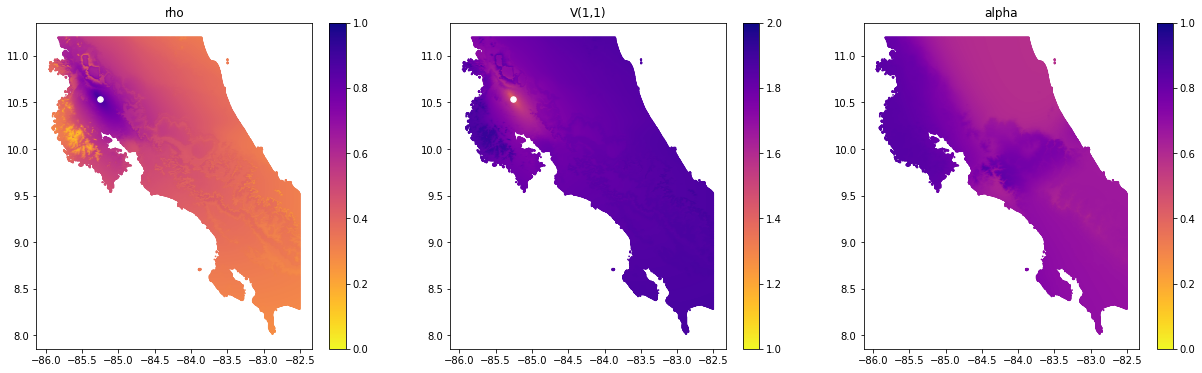

In [ ]:
locations_df, result, result_V, result_a = plot_results(
    list_models[-1], scaler, data_frame_station_attributes, main_station_id = 76026, duration = 1440)

In [ ]:
locations_df["V"] = result_V
locations_df.to_csv("/content/drive/MyDrive/max_stable_76026.csv", index=False)

100%|██████████| 301447/301447 [00:46<00:00, 6424.71it/s]


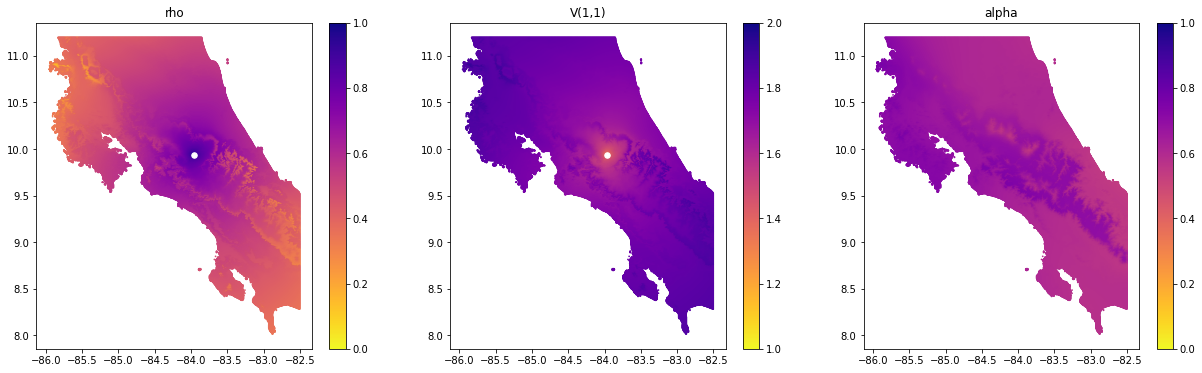

In [ ]:
plot_results(list_models[-1], scaler, data_frame_station_attributes, main_station_id = 84118, duration = 5)

In [ ]:
sample_testing = dataloader_Testing.getSample(10000, verbose = False)
list_models[-1].eval()
print("ok")
# modl.get_mat(sample_testing['input']['cov1'].float().to(device), sample_testing['input']['cov2'].float().to(device))[0][3,:,:]

ok


(10000,)


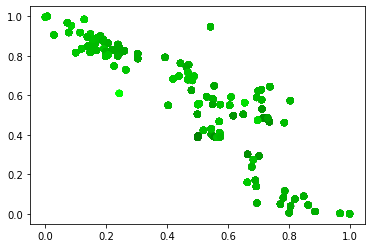

tensor(0.2908, grad_fn=<UnbindBackward0>)
tensor(3.0349, grad_fn=<UnbindBackward0>)


In [ ]:
ind_1, ind_2 = 1,1

sample_1 = sample_testing['input']['cov1'].float()
sample_1[:,3] = 0

rgba_colors = np.zeros((len(sample_1[:,0]),4))
rgba_colors[:,3] = 1.0
vals = list_models[-1].get_mat(sample_1.to(device), 
                                 sample_1.to(device))[0][:,ind_1, ind_2].cpu().detach().numpy()
print(vals.shape)
rgba_colors[:, 1] = vals
rgba_colors[:, 1] = 0.5*(rgba_colors[:, 1] - min(rgba_colors[:, 1]))/(max(rgba_colors[:, 1]) - min(rgba_colors[:, 1]))+0.5
plt.scatter(sample_1[:,0],
            sample_1[:,1],
            color=rgba_colors)
plt.show()

print(min(modl.get_mat(sample_1.to(device), 
                 sample_1.to(device))[0][:,ind_1,ind_2]))
print(max(modl.get_mat(sample_1.to(device), 
                 sample_1.to(device))[0][:,ind_1, ind_2]))

In [ ]:
# def plot_results(model, scaler, DF_location, main_station_id = 69507, duration = 1440):
model = list_models[-1]
duration = 1440
  
ind_1, ind_2 = 1,1

Batch_size = 10000
model.eval()

def get_factor_a_from_model(model, input_cov1):
    return model.factor_a_block(input_cov1[:,0:3].view(-1, 3)).squeeze(1)

locations_df = pd.read_csv("/content/drive/MyDrive/elevation_map.csv")
locations_df.drop("Unnamed: 0", inplace = True, axis=1)
locations_df.rename({"long":"X", "lat":"Y", "alt":"alt"}, inplace=True, axis=1)
locations_df = locations_df[locations_df["alt"] >= 0]
locations_df["log_duration"] = np.log(duration)

locations_df.loc[:, ['X', 'Y', 'alt', "log_duration"]] = scaler.transform(locations_df[['X', 'Y', 'alt', "log_duration"]])
locations_df_tensor = torch.from_numpy(locations_df[["X", "Y", "alt", "log_duration"]].to_numpy())

outputs_0_0 = []
outputs_1_0 = []
outputs_1_1 = []
factor_a = []

ex_sample = dataloader_Training.getSample(2)
sample_in2 = []
# l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
# l_ref = DF_location.loc[main_station_id, ['X', 'Y', 'alt']]
# l_ref["log_duration"] = np.log(duration)
# l1[0, 0:4] = torch.from_numpy(scaler.transform(l_ref.to_frame().transpose()))
# l1[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == main_station_id].iloc[0,0:3].values)
# l1[0,3] = duration
for s in tqdm(range(locations_df_tensor.shape[0])):
    l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
    # l2[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == stations_id[s]].iloc[0,0:3].values)
    l2[0, 0:3] = locations_df_tensor[s,0:3]
    l2[0,3] = scaler.transform(np.array([[0, 0, 0, np.log(duration)]]))[0,-1]
    # sample_in1.append(l1)
    sample_in2.append(l2)

    if (s+1)%Batch_size == 0:
      with torch.no_grad():
        # res_mod = model.get_rho(torch.cat(sample_in1, axis = 0).float().to(device), 
        #                           torch.cat(sample_in2, axis = 0).float().to(device))
        mat = modl.get_mat(torch.cat(sample_in2, axis = 0).float().to(device), 
                 torch.cat(sample_in2, axis = 0).float().to(device))[0]
        outputs_0_0.append(mat[:,0, 0])
        outputs_1_0.append(mat[:,1, 0])
        outputs_1_1.append(mat[:,1, 1])

        factor_a.append(model.get_factor(torch.cat(sample_in2, axis = 0).float().to(device)))

      # sample_in1 = []
      sample_in2 = []

if sample_in2 is not []:
    with torch.no_grad():
        mat = modl.get_mat(torch.cat(sample_in2, axis = 0).float().to(device), 
                 torch.cat(sample_in2, axis = 0).float().to(device))[0]
        outputs_0_0.append(mat[:,0, 0])
        outputs_1_0.append(mat[:,1, 0])
        outputs_1_1.append(mat[:,1, 1])

        factor_a.append(model.get_factor(torch.cat(sample_in2, axis = 0).float().to(device)))
      # res_mod = model.get_rho(torch.cat(sample_in1, axis = 0).float().to(device), 
      #                             torch.cat(sample_in2, axis = 0).float().to(device))
      # outputs.append(res_mod.cpu().detach().view(-1, 1).numpy())

      # if model.smooth_2 is not None:
      #   # factor_a = get_factor_a_from_model(model, torch.cat(sample_in2, axis = 0).float().to(device))
      #   factor_a = model.get_factor(torch.cat(sample_in2, axis = 0).float().to(device))
      #   output_a.append(factor_a.cpu().detach().view(-1, 1).numpy())
  
locations_df.loc[:, ['X', 'Y', 'alt', "log_duration"]] = scaler.inverse_transform(locations_df[['X', 'Y', 'alt', "log_duration"]])

outputs_0_0 = np.hstack(outputs_0_0)
outputs_1_0 = np.hstack(outputs_1_0)
outputs_1_1 = np.hstack(outputs_1_1)
factor_a = np.hstack(factor_a)


  # import matplotlib.cm as cm

  # # location = scaler.inverse_transform(df_input[df_input["id"] == main_station_id].iloc[:,0:4])
  # location = DF_location.loc[main_station_id, ['X', 'Y', 'alt']].to_frame().transpose()

  # if model.smooth_2 is not None:
  #   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21,6))
  # else:
  #   fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

  # im1 = ax1.scatter(locations_df['X'], locations_df['Y'], c=result, cmap='plasma_r', s = 0.5, vmin=0, vmax=1)
  # fig.colorbar(im1, ax=ax1, orientation='vertical', norm = mpl.colors.Normalize(vmin=0, vmax=1))
  # ax1.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
  # ax1.set_title("rho")

  # im2 = ax2.scatter(locations_df['X'], locations_df['Y'], c=result_V, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
  # fig.colorbar(im2, ax=ax2, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
  # ax2.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
  # ax2.set_title("V(1,1)")

  # if model.smooth_2 is not None:
  #   im3 = ax3.scatter(locations_df['X'], locations_df['Y'], c=result_a, cmap='plasma_r', s = 0.5, vmin=0, vmax=1)
  #   fig.colorbar(im3, ax=ax3, orientation='vertical', norm = mpl.colors.Normalize(vmin=0, vmax=1))
  #   ax3.set_title("alpha")

  # plt.show()

model.train()


100%|██████████| 301447/301447 [00:43<00:00, 6975.42it/s]


model_non_stationarity_t_extremal(
  (linearBlock): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): Sigmoid()
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): Sigmoid()
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=10, out_features=3, bias=True)
  )
  (factor_a_block): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): Sigmoid()
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


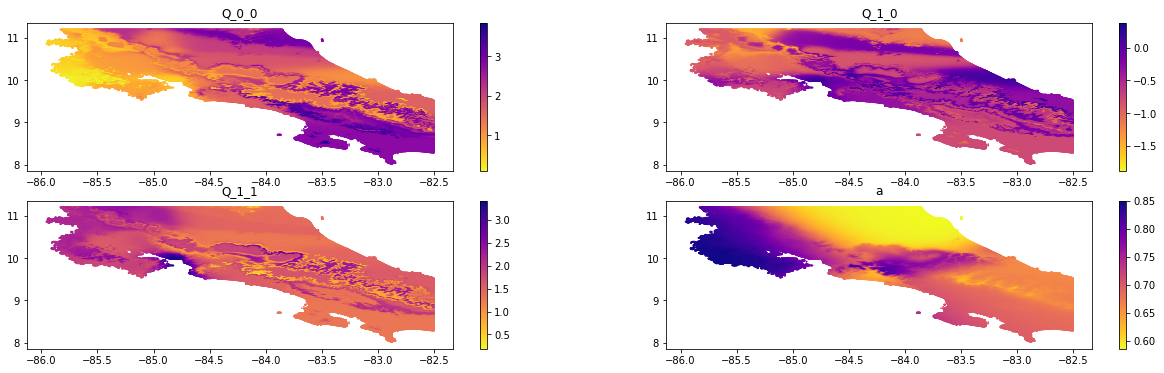

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (21,6))

im1 = ax1.scatter(locations_df['X'], locations_df['Y'], c=outputs_0_0, cmap='plasma_r', s = 0.5)
fig.colorbar(im1, ax=ax1, orientation='vertical')
# ax1.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
ax1.set_title("Q_0_0")

im2 = ax2.scatter(locations_df['X'], locations_df['Y'], c=outputs_1_0, cmap='plasma_r', s = 0.5)
fig.colorbar(im2, ax=ax2, orientation='vertical')
# ax2.scatter(x = location.iloc[0, 0], y = location.iloc[0, 1],c = "white", s = 30)
ax2.set_title("Q_1_0")

im3 = ax3.scatter(locations_df['X'], locations_df['Y'], c=outputs_1_1, cmap='plasma_r', s = 0.5)
fig.colorbar(im3, ax=ax3, orientation='vertical')
ax3.set_title("Q_1_1")

im4 = ax4.scatter(locations_df['X'], locations_df['Y'], c=factor_a, cmap='plasma_r', s = 0.5)
fig.colorbar(im4, ax=ax4, orientation='vertical')
ax4.set_title("a")
plt.show()

In [ ]:
locations_df["Q_0_0"] = outputs_0_0
locations_df["Q_1_0"] = outputs_1_0
locations_df["Q_1_1"] = outputs_1_1
locations_df["a"] = factor_a

locations_df.to_csv("/content/drive/MyDrive/pred_model_max_stable_cov_matrix.csv", index=False)

In [ ]:
sample_testing['input']["cov1"].float()[0,:]

tensor([6.3553e-01, 4.6169e-01, 2.9587e-01, 1.0000e+00, 1.4400e+03])

In [ ]:
s = 98006

l1 = sample_testing['input']["cov1"].float()[0,:].view(1, -1)
l_ref = data_frame_station_attributes.loc[s, ['X', 'Y', 'alt']]
l_ref["log_duration"] = np.log(5)
l1[0, 0:4] = torch.from_numpy(scaler.transform(l_ref.to_frame().transpose()))

list_ellipses = []
for modl_b in list_models:
  modl_b.eval()
  list_ellipses.append(modl_b.get_mat(l1.to(device), l1.to(device))[0].cpu().detach().numpy()[0])

In [ ]:
list_ellipses[-1]

array([[ 0.99974954, -0.10383768],
       [-0.10383768,  1.5204529 ]], dtype=float32)

In [ ]:
# https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(cov, mean_x, mean_y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    # if x.size != y.size:
    #     raise ValueError("x and y must be the same size")

    # cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    # mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
list_ellipses[-1]

array([[[ 0.7305334 , -0.00489869],
        [-0.00489869,  0.80668867]]], dtype=float32)

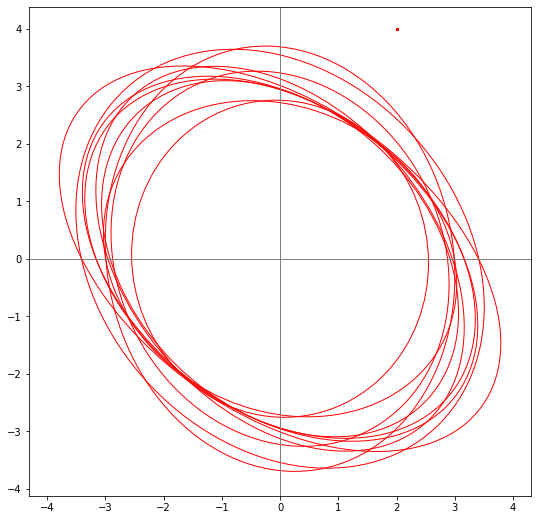

In [ ]:
np.random.seed(0)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for cov_ in list_ellipses:
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

    confidence_ellipse(cov_, 0.0, 0.0, ax, edgecolor='red')

    ax.scatter(mu[0], mu[1], c='red', s=3)
plt.show()

100%|██████████| 301447/301447 [00:45<00:00, 6556.33it/s]


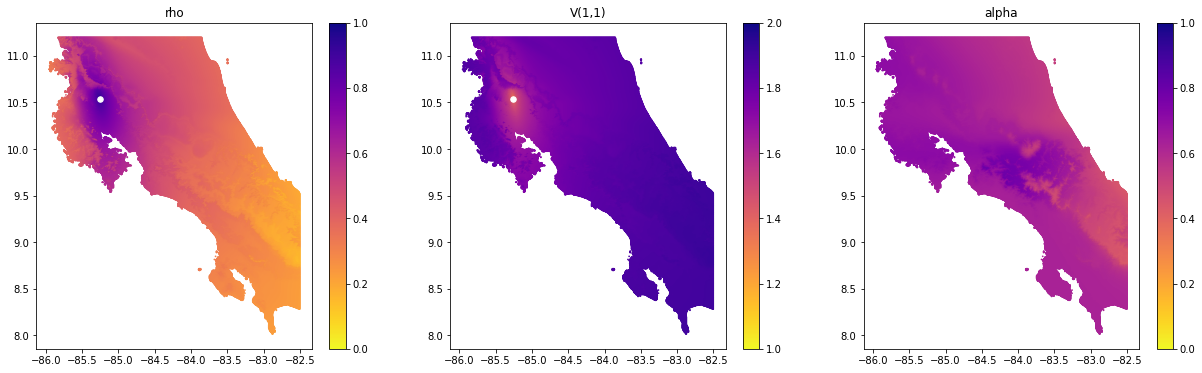

In [ ]:
locations_df_, result_, result_V_, result_a_ = plot_results(
    list_models[-2], scaler, data_frame_station_attributes, main_station_id = 76026, duration = 1440
    )

In [ ]:
max(result_V_)

array([1.92076817])

In [ ]:
# list_models = [modl]
Stations_of_interest = [69507, 77001, 75022, 84118, 76026, 98006]

from os import name
from tqdm import tqdm

duration = 1440
stations2 = list(set(monthly_maxima_labelMonth["id"]))
duration = list(set(monthly_maxima_labelMonth["dur"]))

results_all = []
for dur in tqdm(duration):
  for s1 in Stations_of_interest:
    for s2 in stations2:
      l1 = sample_testing['input']["cov1"].float()[0,:].view(1, -1)
      l_ref = data_frame_station_attributes.loc[s1, ['X', 'Y', 'alt']]
      l_ref["log_duration"] = np.log(dur)
      l1[0, 0:4] = torch.from_numpy(scaler.transform(l_ref.to_frame().transpose()))


      l2 = sample_testing['input']["cov1"].float()[0,:].view(1, -1)
      l_ref = data_frame_station_attributes.loc[s2, ['X', 'Y', 'alt']]
      l_ref["log_duration"] = np.log(dur)
      l2[0, 0:4] = torch.from_numpy(scaler.transform(l_ref.to_frame().transpose()))

      outputs = []
      output_V = []
      for b, model_b in enumerate(list_models):
        model_b.eval()
        with torch.no_grad():
          res_mod = model_b.get_rho(torch.cat([l1], axis = 0).float().to(device), 
                                  torch.cat([l2], axis = 0).float().to(device))
          outputs.append(res_mod.cpu().detach().view(-1, 1).numpy())
          # if model_b.smooth_2 is not None:
          #   factor_a = model_b.get_factor(torch.cat([l2], axis = 0).float().to(device))
          #   output_a.append(factor_a.cpu().detach().view(-1, 1).numpy())

          df_plus1 = model_b.df + 1
          output_V.append(2*t_student.cdf((1-outputs[-1])/(df_plus1**(-1/2) * np.sqrt((1-outputs[-1]**2))), df_plus1))

      estimates_rho = np.mean(np.vstack(outputs))
      var_rho = np.var(np.vstack(outputs))
      estimates_V = np.mean(np.vstack(output_V))
      var_V = np.var(np.vstack(output_V))
      results_all.append(pd.DataFrame(data = {"s1": s1, "s2":s2, "dur": dur,
                                     "rho": estimates_rho, "var_rho": var_rho,
                                     "V": estimates_V, "var_V": var_V}, index=[0]))

100%|██████████| 10/10 [05:07<00:00, 30.76s/it]


In [ ]:
results_all = pd.concat(results_all)

In [ ]:
results_all.to_csv("/content/drive/MyDrive/pred_model_max_stable_stations.csv", index=False)

In [ ]:
results_all

,s1,s2,dur,rho,var_rho,V,var_V
0,69507,69632,1440,0.649402,0.000668,1.697476,0.000355
0,69507,69634,1440,0.720140,0.001187,1.637214,0.000867
0,69507,69636,1440,0.711835,0.001077,1.644983,0.000779
0,69507,69638,1440,0.706067,0.000932,1.650296,0.000732
0,69507,69654,1440,0.672186,0.003315,1.676999,0.001697
...,...,...,...,...,...,...,...
0,98006,69620,30,0.526554,0.000365,1.778277,0.000116
0,98006,69624,30,0.540582,0.000449,1.770217,0.000136
0,98006,69626,30,0.557902,0.000235,1.760082,0.000084
0,98006,69628,30,0.443713,0.000381,1.820597,0.000082


TEST:  4.054049
tensor([[ 2.9490, -0.2640],
        [-0.2640,  1.8652]])


100%|██████████| 301447/301447 [00:44<00:00, 6699.19it/s]


               X          Y     alt
69507 -84.213033  10.283686  1010.0


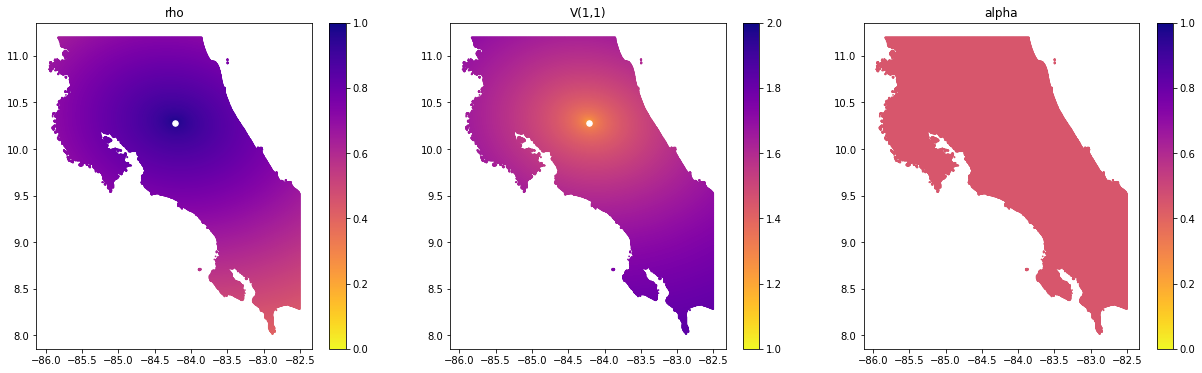

---------------------------------------------------------------
TEST:  4.008297
tensor([[ 1.2857, -0.0339],
        [-0.0339,  0.9353]])


100%|██████████| 301447/301447 [00:44<00:00, 6719.81it/s]


               X          Y     alt
69507 -84.213033  10.283686  1010.0


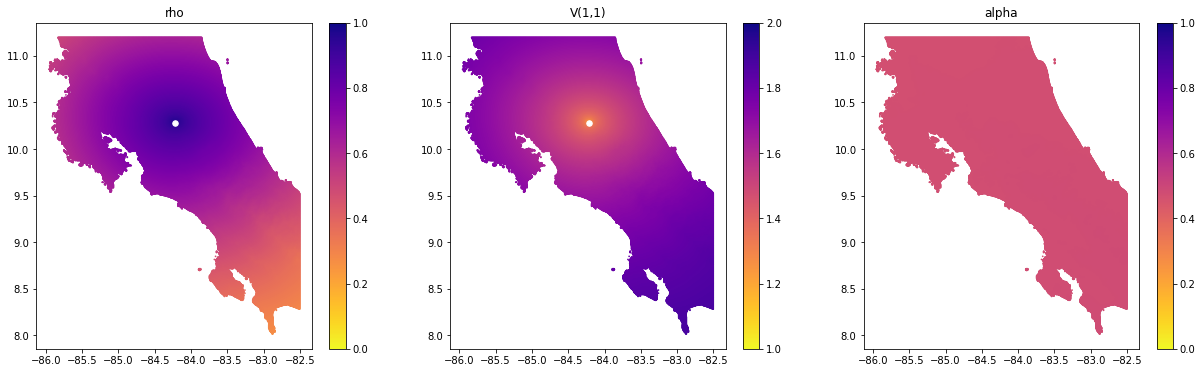

---------------------------------------------------------------
TEST:  3.9938138
tensor([[ 1.0759, -0.1677],
        [-0.1677,  0.7348]])


100%|██████████| 301447/301447 [00:45<00:00, 6662.08it/s]


               X          Y     alt
69507 -84.213033  10.283686  1010.0


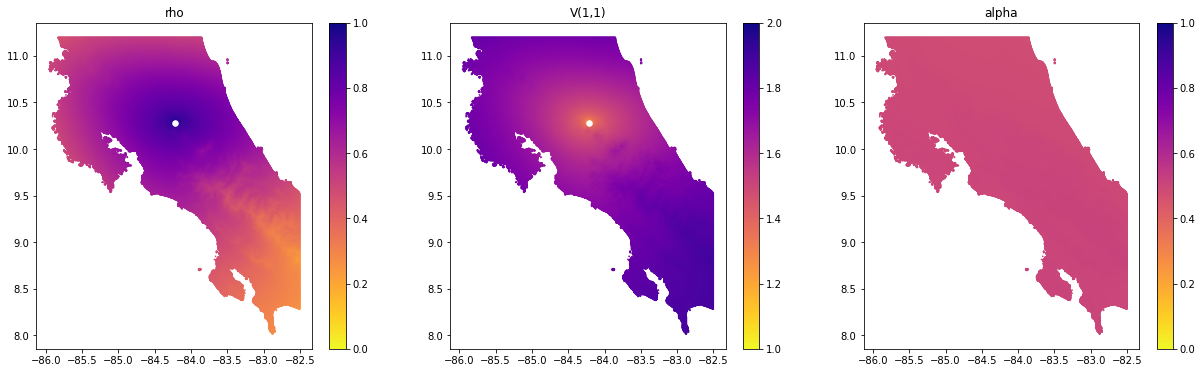

---------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
plot_evolution = True
modl.train()

loss_training = []
loss_testing = []
sample_testing = dataloader_Testing.getSample(2000)
for j in range(20000):
    # sample_training = dataloader_Training.getSample(1000)
    if j % 10 == 0:
      modl.eval()
      # sample_training = dataloader_Training.getSample(100)
      # sample_testing = dataloader_Testing.getSample(100)
      sample_training = dataloader_Training.getSample(1000)
      with torch.no_grad():
        outputs = modl(sample_testing['input']['cov1'].float().to(device), 
                       sample_testing['input']['cov2'].float().to(device),
                       sample_testing['output']['int1'].float().to(device),
                       sample_testing['output']['int2'].float().to(device))
        loss_testing.append(outputs.cpu().detach().numpy())
        print("TEST: ", loss_testing[-1])
        print(modl.get_mat(sample_testing['input']['cov1'].float().to(device), sample_testing['input']['cov2'].float().to(device))[0][0,:,:])
        # print(modl.get_mat(sample_testing['input']['cov1'].float().to("cuda"), sample_testing['input']['cov2'].float().to("cuda"))[0][0,:,:])

      modl.train()

    optimizer.zero_grad()
    outputs = modl(sample_training['input']['cov1'].float().to(device), 
                  sample_training['input']['cov2'].float().to(device),
                  sample_training['output']['int1'].float().to(device),
                  sample_training['output']['int2'].float().to(device))
    outputs.backward()
    optimizer.step()
    lr_scheduler.step()
    if j % 10 == 0:
      modl.eval()
      loss_training.append(outputs.cpu().detach().numpy())
      # print("TRAIN: ", loss_training[-1])
      # print(modl.get_mat(sample_training['input']['cov1'].float().to("cuda"), sample_training['input']['cov2'].float().to("cuda"))[0][0,:,:])

      if plot_evolution:
        plot_results(modl, scaler, data_frame_station_attributes, duration = 1440)

      modl.train()

      print("---------------------------------------------------------------")

    if (j+1) % 100 == 0:
      for g in optimizer.param_groups:
        g['lr'] = g['lr']/2
        print(g['lr'])